# Lab 5 : Price Impact Modeling

**Hugo Yeremian - Martín Pasche**

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from dataclasses import dataclass
import scipy.optimize as sco
sns.set(style='whitegrid', context='talk')
from tqdm import tqdm
from scipy.stats import binned_statistic


The goal of this lab is to reproduce some of the results of Z. Eisler, J.-P. Bouchaud, and J. Kockelkoren. “The price impact of order book events: market orders, limit orders and cancellations”. In: Quantitative Finance 12.9 (2012). Observe that in order to plot a function of the lag $\ell$, you may not need to compute the function for all $\ell$.

In [2]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

files = get_all_files(os.path.join('Data', 'SG'))

df_sgs = []

for i, file in enumerate(files):
    df_sg_small = pd.read_csv(os.path.join('Data', 'SG', file), index_col = 0)
    df_sgs.append(df_sg_small)
    if i == 1:
        break  # < ----------------- remove this line to read all files
df_sg = pd.concat(df_sgs)
df_sg['ets'] = pd.to_datetime(df_sg['ets'], format='%Y%m%d:%H:%M:%S.%f')
df_sg = df_sg.sort_values(by='ets')
df_sg = df_sg.set_index('ets')
#df_sg = df_sg.iloc[:df_sg.shape[0]//30]
df_sg

,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
ets,,,,,,,,
2017-01-25 09:01:00.030626,A,46005,16107,B,46410,1293,46475,502
2017-01-25 09:01:00.030695,A,46760,16107,S,46410,1293,46475,502
2017-01-25 09:01:01.337705,A,46400,320,B,46410,1293,46475,502
2017-01-25 09:01:01.548950,C,46475,127,S,46410,1293,46475,375
2017-01-25 09:01:01.557687,A,46405,119,B,46410,1293,46475,375
...,...,...,...,...,...,...,...,...
2017-01-27 17:29:59.043211,C,47485,264,S,47425,1572,47435,231
2017-01-27 17:29:59.043223,C,47500,264,S,47425,1572,47435,231
2017-01-27 17:29:59.051275,C,47295,563,B,47425,1572,47435,231


In [3]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

files = get_all_files(os.path.join('Data', 'SG'))

dfs = []

"""
for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('Data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    if i == 1:
        break  # < ----------------- remove this line to read all files
"""

df_bnp = pd.read_csv(os.path.join('Data', 'BNPP', 'BNPP_20170125.csv.gz'), index_col = 0)
df_bnp['ets'] = pd.to_datetime(df_bnp['ets'], format='%Y%m%d:%H:%M:%S.%f')
df_bnp = df_bnp.sort_values(by='ets')
df_bnp = df_bnp.set_index('ets')
#df_bnp = df_bnp.iloc[:df_bnp.shape[0]//30]
df_bnp

,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
ets,,,,,,,,
2017-01-25 09:00:14.351715,A,60770,169,B,60770,169,60780,200
2017-01-25 09:01:00.013711,A,60270,19667,B,60800,1201,60850,358
2017-01-25 09:01:00.013787,A,61230,19667,S,60800,1201,60850,358
2017-01-25 09:01:00.051085,A,60850,89,S,60800,1201,60850,447
2017-01-25 09:01:00.052288,A,60850,230,S,60800,1201,60850,677
...,...,...,...,...,...,...,...,...
2017-01-25 17:29:59.045118,C,62420,242,S,62360,430,62380,1044
2017-01-25 17:29:59.045131,C,62430,235,S,62360,430,62380,1044
2017-01-25 17:29:59.045166,C,62440,227,S,62360,430,62380,1044


## Lab Instructions:

### 1. **Plot the sign**  
   Plot the sign autocorrelation function  
   $\langle \epsilon_t, \epsilon_{t+\ell} \rangle$ and the side autocorrelation function $\langle s_t, s_{t+\ell} \rangle.$


**Reminder :** The sign of a trade designates the side of aggressor, i.e. the order triggering the transaction.

- +1 denotes an aggressive buyer, typically a **buy market order** removing liquidity on the
ask side of the LOB.
- −1 denotes an aggressive seller, typically **sell market order** removing liquidity on the bid
side of the LOB.

**Remark :** Trade sign is an important information in microstructure theory: it is often assumed that
the aggressive buyer/seller is trades with some knowledge/information, hence its
impatience.

#### 1.1. & 1.2 Autocorrelation of the trades : $\langle \epsilon_t, \epsilon_{t+\ell} \rangle$, Autocorrelation of the sides : $\langle s_t, s_{t+\ell} \rangle$

In [4]:
def compute_sign(row):
    etype = row['etype']
    side = row['eside']
    eqty = row['eqty']

    if etype == 'T':
        return +1 if side == 'S' else -1

    elif etype == 'A':
        return -1 if side == 'S' else +1

    elif etype == 'M':
        if eqty < 0:  
            return +1 if side == 'B' else -1
        return 0  
    
    elif etype == 'C':
        return 0

    return np.nan

In [5]:
def preprocess_df(df):
    df['trade_sign'] = df.apply(compute_sign, axis=1)
    df['side_signed'] = df['eside'].map({'B': +1, 'S': -1})
    return df

def autocorrelation(x, max_lag):
    n = len(x)
    result = []
    x_mean = np.mean(x)
    x_var = np.var(x)
    for lag in tqdm(range(1, max_lag + 1)):
        cov = np.mean((x[:-lag] - x_mean) * (x[lag:] - x_mean))
        result.append(cov / x_var)
    return np.array(result)

In [6]:
df_sg = preprocess_df(df_sg)
df_bnp = preprocess_df(df_bnp)

In [7]:
max_lag = 10_000
lags = np.arange(1, max_lag + 1)

auto_sg_eps = autocorrelation(df_sg['trade_sign'].values, max_lag)
auto_sg_side = autocorrelation(df_sg['side_signed'].values, max_lag)

auto_bnp_eps = autocorrelation(df_bnp['trade_sign'].values, max_lag)
auto_bnp_side = autocorrelation(df_bnp['side_signed'].values, max_lag)


100%|██████████| 10000/10000 [00:09<00:00, 1081.36it/s]


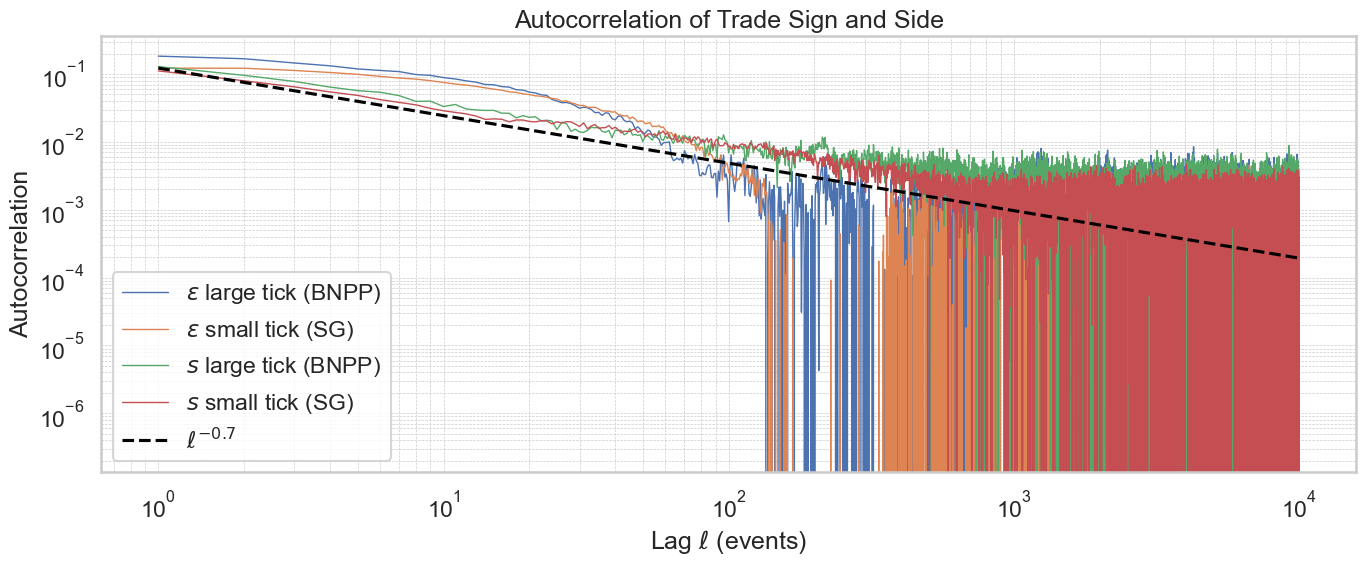

In [8]:
plt.figure(figsize=(14, 6))

plt.loglog(lags, auto_bnp_eps, label=r'$\varepsilon$ large tick (BNPP)', linewidth=1)
plt.loglog(lags, auto_sg_eps, label=r'$\varepsilon$ small tick (SG)', linewidth=1)
plt.loglog(lags, auto_bnp_side, label=r'$s$ large tick (BNPP)', linewidth=1)
plt.loglog(lags, auto_sg_side, label=r'$s$ small tick (SG)', linewidth=1)

reference_line = lags**(-0.7)
reference_line *= auto_sg_eps[0] / reference_line[0]
plt.loglog(lags, reference_line, '--', label=r'$\ell^{-0.7}$', color='black')


plt.xlabel('Lag $\\ell$ (events)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Trade Sign and Side')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
def log_smooth(x, y, num=100):
    """
    Smooth autocorrelation curves using log-binned averaging.
    """

    log_lags = np.log10(x)
    bins = np.logspace(np.log10(x[0]), np.log10(x[-1]), num=num)
    
    y_smooth, _, _ = binned_statistic(x, y, statistic='mean', bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    return bin_centers, y_smooth

In [10]:
sg_eps_x, sg_eps_y = log_smooth(lags, auto_sg_eps)
sg_side_x, sg_side_y = log_smooth(lags, auto_sg_side)
bnp_eps_x, bnp_eps_y = log_smooth(lags, auto_bnp_eps)
bnp_side_x, bnp_side_y = log_smooth(lags, auto_bnp_side)


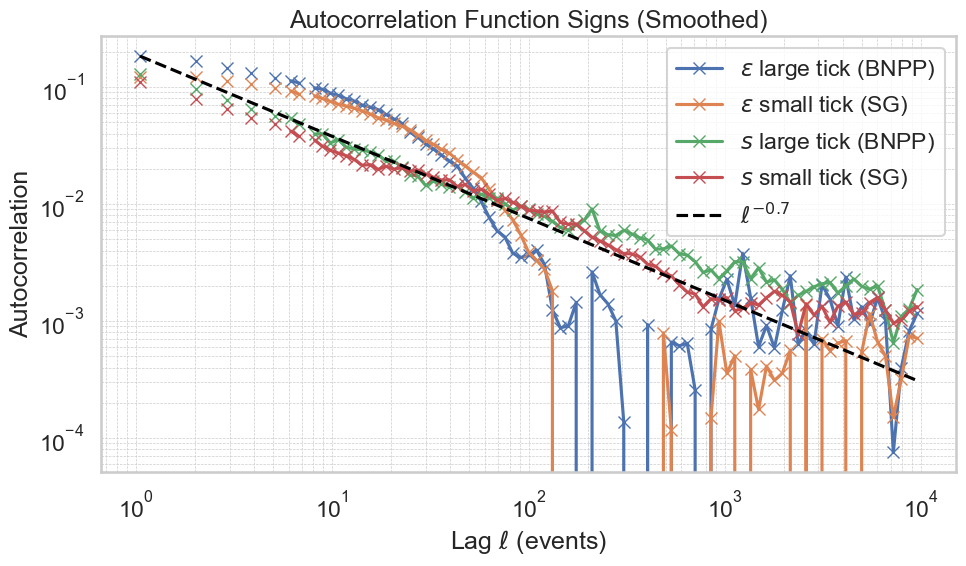

In [11]:
plt.figure(figsize=(10, 6))

plt.loglog(bnp_eps_x, bnp_eps_y, label=r'$\varepsilon$ large tick (BNPP)', marker='x')
plt.loglog(sg_eps_x, sg_eps_y, label=r'$\varepsilon$ small tick (SG)', marker='x')
plt.loglog(bnp_side_x, bnp_side_y, label=r'$s$ large tick (BNPP)', marker='x')
plt.loglog(sg_side_x, sg_side_y, label=r'$s$ small tick (SG)', marker='x')

ref = bnp_eps_x**(-0.7)
ref *= bnp_eps_y[0] / ref[0]
plt.loglog(bnp_eps_x, ref, '--', color='black', label=r'$\ell^{-0.7}$')

plt.xlabel('Lag $\\ell$ (events)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function Signs (Smoothed)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


##### **Interpretation :**



### 2. **Empirical Response Functions**  
   Compute and plot the empirical response functions  
   $$
   R_\pi(\ell)
   $$  
   for each of the 6 types of events $\pi$.

**Reminder :**

Order typology :

-  **Z. Eisler, J.-P. Bouchaud, and J. Kockelkoren** proposes several propagator models to analyze impact of LOB events.

-  Orders are classified by type (limit, market, cancel) and aggressiveness (the order moves
the midprice, or does not move the mid-price).



There are 4 types of orders in the dataset **Data/SG :**

- A: add limit order
- T: Trade (takes the best price)
- M: Modification
- C: Cancel



There are **6 types of events $\pi$ :**

- **$\pi$ = MO0**: Market order, volume < outstanding volume at the best
- **$\pi$ = MO1**: Market order, volume ≥ outstanding volume at the best
- **$\pi$ = CA0**: Partial cancellation of the bid/ask queue
- **$\pi$ = LO0**: Limit order at the current best bid/ask
- **$\pi$ = CA1**: Complete cancellation of the best bid/ask
- **$\pi$ = LO1**: Limit order inside the spread



And now concerning the computation of the **response function** $ R_{\pi}(\ell) $ which describes the average price movement $ \ell $ events after the occurrence of an order of a given type $ \pi $:

$$
R_{\pi}(\ell) = \langle (p_{t+\ell} - p_t) \epsilon_t \mid \pi_t = \pi \rangle
$$

This response function is a **global market response**: it is the combination of a "bare" impact of the order and the correlation functions.

The **mid-price** is defined as :

$$Mid\text{-}Price = \frac{ap_{0}(t) + bp_{0}(t)}{2}$$

In [12]:
df_sgg = df_sg.copy()

In [ ]:
df_sgg["bp0_prev"] = df_sgg["bp0"].shift(1)
df_sgg["bq0_prev"] = df_sgg["bq0"].shift(1)
df_sgg["ap0_prev"] = df_sgg["ap0"].shift(1)
df_sgg["aq0_prev"] = df_sgg["aq0"].shift(1)

# === Trades are always relevant ===
trades_flag = (df_sgg["etype"] == "T")

# === Cancel bid flag ===
cancel_bid_flag = (
    (df_sgg["etype"] == "C") &
    (df_sgg["eside"] == "B") &
    (df_sgg["eprice"] == df_sgg["bp0_prev"]) &
    (
        (df_sgg["bq0"] < df_sgg["bq0_prev"]) |
        (df_sgg["bp0"] != df_sgg["bp0_prev"])
    )
)

# === Cancel ask flag ===
cancel_ask_flag = (
    (df_sgg["etype"] == "C") &
    (df_sgg["eside"] == "S") &
    (df_sgg["eprice"] == df_sgg["ap0_prev"]) &
    (
        (df_sgg["aq0"] < df_sgg["aq0_prev"]) |
        (df_sgg["ap0"] != df_sgg["ap0_prev"])
    )
)

# === Limit bid flag ===
limit_bid_flag = (
    (df_sgg["etype"] == "A") &
    (df_sgg["eside"] == "B") &
    (
        ((df_sgg["eprice"] == df_sgg["bp0"]) & (df_sgg["bq0"] > df_sgg["bq0_prev"])) |
        (df_sgg["bp0"] > df_sgg["bp0_prev"])
    )
)

# === Limit ask flag ===
limit_ask_flag = (
    (df_sgg["etype"] == "A") &
    (df_sgg["eside"] == "S") &
    (
        ((df_sgg["eprice"] == df_sgg["ap0"]) & (df_sgg["aq0"] > df_sgg["aq0_prev"])) |
        (df_sgg["ap0"] < df_sgg["ap0_prev"])
    )
)

# === Combine all relevant events ===
flagged_events = (
    trades_flag |
    cancel_bid_flag |
    cancel_ask_flag |
    limit_bid_flag |
    limit_ask_flag
)

# === Create FLAG column: 1 if flagged, else 0 ===
df_sgg["FLAG"] = flagged_events.astype(int)


In [14]:
df_sgg["mid"] = (df_sgg["bp0"] + df_sgg["ap0"]) / 2
df_sgg["mid_prev"] = (df_sgg["bp0_prev"] + df_sgg["ap0_prev"]) / 2

In [15]:
df_sgg["event_type"] = None 

# === Market Orders ===
df_sgg.loc[
    (df_sgg["etype"] == "T") &
    (df_sgg["eside"] == "B") &
    (df_sgg["eqty"] >= df_sgg["aq0_prev"]),
    "event_type"
] = "MO^1"

df_sgg.loc[
    (df_sgg["etype"] == "T") &
    (df_sgg["eside"] == "B") &
    (df_sgg["eqty"] < df_sgg["aq0_prev"]),
    "event_type"
] = "MO^0"

df_sgg.loc[
    (df_sgg["etype"] == "T") &
    (df_sgg["eside"] == "S") &
    (df_sgg["eqty"] >= df_sgg["bq0_prev"]),
    "event_type"
] = "MO^1"

df_sgg.loc[
    (df_sgg["etype"] == "T") &
    (df_sgg["eside"] == "S") &
    (df_sgg["eqty"] < df_sgg["bq0_prev"]),
    "event_type"
] = "MO^0"

# === Cancel full (CA1) ===
df_sgg.loc[cancel_bid_flag & (df_sgg["bp0"] != df_sgg["bp0_prev"]), "event_type"] = "CA^1"
df_sgg.loc[cancel_ask_flag & (df_sgg["ap0"] != df_sgg["ap0_prev"]), "event_type"] = "CA^1"

# === Cancel partial (CA0) ===
df_sgg.loc[cancel_bid_flag & (df_sgg["bp0"] == df_sgg["bp0_prev"]), "event_type"] = "CA^0"
df_sgg.loc[cancel_ask_flag & (df_sgg["ap0"] == df_sgg["ap0_prev"]), "event_type"] = "CA^0"

# === LO1: inside the spread (improving best price) ===
df_sgg.loc[limit_bid_flag & (df_sgg["bp0"] > df_sgg["bp0_prev"]), "event_type"] = "LO^1"
df_sgg.loc[limit_ask_flag & (df_sgg["ap0"] < df_sgg["ap0_prev"]), "event_type"] = "LO^1"

# === LO0: at best, increasing volume ===
df_sgg.loc[limit_bid_flag & (df_sgg["bp0"] == df_sgg["bp0_prev"]), "event_type"] = "LO^0"
df_sgg.loc[limit_ask_flag & (df_sgg["ap0"] == df_sgg["ap0_prev"]), "event_type"] = "LO^0"


In [16]:
df_sgg[df_sgg['event_type'] == 'CA^0']

,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,trade_sign,side_signed,bp0_prev,bq0_prev,ap0_prev,aq0_prev,FLAG,mid,mid_prev,event_type
ets,,,,,,,,,,,,,,,,,,
2017-01-25 09:01:01.548950,C,46475,127,S,46410,1293,46475,375,0,-1,46410.0,1293.0,46475.0,502.0,1,46442.5,46442.5,CA^0
2017-01-25 09:01:05.427547,C,46545,202,S,46500,2199,46545,183,0,-1,46500.0,2199.0,46545.0,385.0,1,46522.5,46522.5,CA^0
2017-01-25 09:01:06.465766,C,46500,2199,B,46500,394,46550,300,0,1,46500.0,2593.0,46550.0,300.0,1,46525.0,46525.0,CA^0
2017-01-25 09:01:07.345075,C,46500,194,B,46500,200,46545,200,0,1,46500.0,394.0,46545.0,200.0,1,46522.5,46522.5,CA^0
2017-01-25 09:01:07.550530,C,46490,230,B,46490,19,46545,116,0,1,46490.0,249.0,46545.0,116.0,1,46517.5,46517.5,CA^0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-27 17:29:56.061156,C,47435,105,S,47425,1559,47435,227,0,-1,47425.0,1559.0,47435.0,332.0,1,47430.0,47430.0,CA^0
2017-01-27 17:29:56.401089,C,47425,88,B,47425,1471,47435,227,0,1,47425.0,1559.0,47435.0,227.0,1,47430.0,47430.0,CA^0
2017-01-27 17:29:57.215966,C,47425,191,B,47425,1280,47435,227,0,1,47425.0,1471.0,47435.0,227.0,1,47430.0,47430.0,CA^0


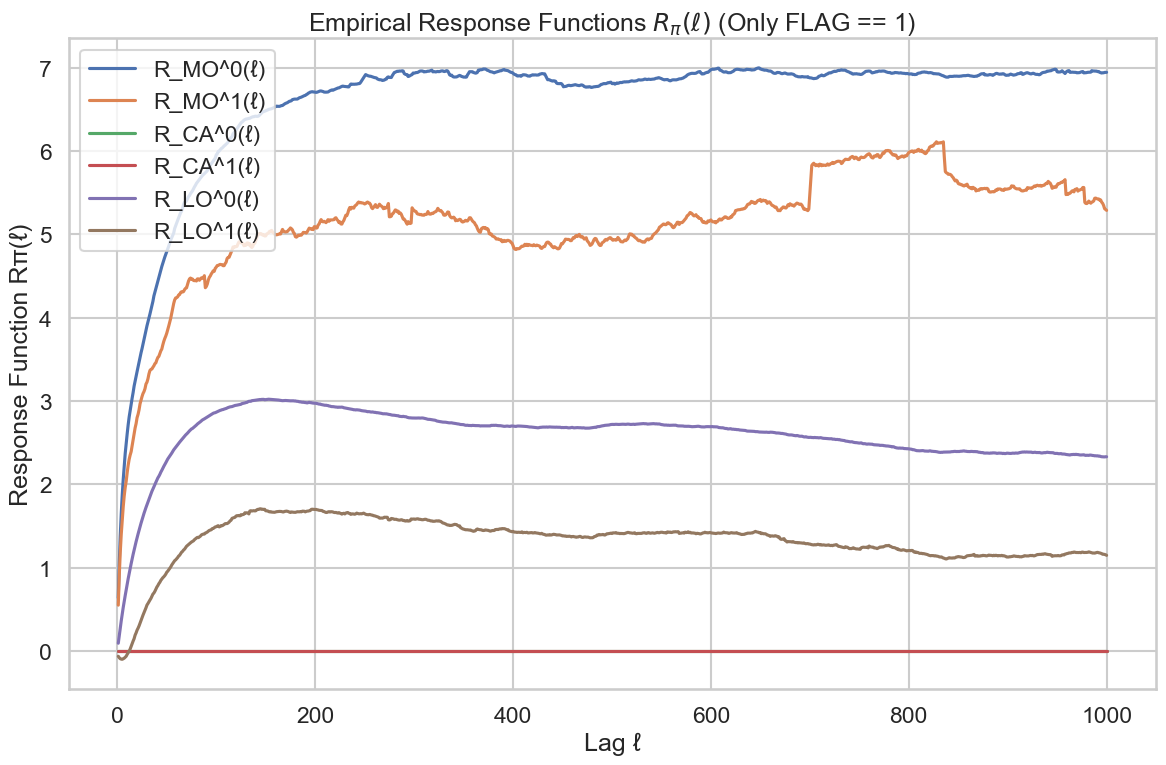

In [ ]:
max_lag = 1_000
lags = np.arange(1, max_lag + 1)

# Define the six types of events
event_types = ['MO^0', 'MO^1', 'CA^0', 'CA^1', 'LO^0', 'LO^1']

# Filter only relevant events
df_flagged = df_sgg[df_sgg["FLAG"] == 1].copy()

# Convert relevant columns to numpy arrays
mid_prices = df_sgg["mid"].values
trade_signs = df_sgg["trade_sign"].values
event_type_series = df_sgg["event_type"].values

# Initialize the response functions dictionary
response_functions = {et: [] for et in event_types}

for et in event_types:
    event_mask = (event_type_series == et) & (df_sgg["FLAG"].values == 1)
    indices = np.where(event_mask)[0]

    for lag in lags:
        valid_indices = indices[indices + lag < len(df_sgg)]
        if len(valid_indices) == 0:
            response = 0
        else:
            price_diff = mid_prices[valid_indices + lag] - mid_prices[valid_indices]
            sign = trade_signs[valid_indices]
            response = np.mean(price_diff * sign)
        response_functions[et].append(response)



plt.figure(figsize=(12, 8))
for et in event_types:
    plt.plot(lags, response_functions[et], label=f'R_{et}(ℓ)')
plt.xlabel('Lag ℓ')
plt.ylabel('Response Function Rπ(ℓ)')
plt.title('Empirical Response Functions $R_\\pi(\\ell)$ (Only FLAG == 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
def log_smooth(x, y, n_bins=100):
    """
    Smooth a curve (x, y) using logarithmic binning.
    Returns: (smoothed_x, smoothed_y)
    """
    
    log_x = np.logspace(np.log10(x[0]), np.log10(x[-1]), n_bins)
    smoothed_x = []
    smoothed_y = []

    for i in range(len(log_x) - 1):
        mask = (x >= log_x[i]) & (x < log_x[i + 1])
        if np.any(mask):
            smoothed_x.append(np.mean(x[mask]))
            smoothed_y.append(np.mean(y[mask]))

    return np.array(smoothed_x), np.array(smoothed_y)


In [19]:
# Smooth each response curve
response_functions_smoothed = {}

for et in event_types:
    if et in response_functions:  # skip missing keys if any
        x = np.array(lags)
        y = np.array(response_functions[et])
        smoothed_x, smoothed_y = log_smooth(x, y, n_bins=100)
        response_functions_smoothed[et] = (smoothed_x, smoothed_y)


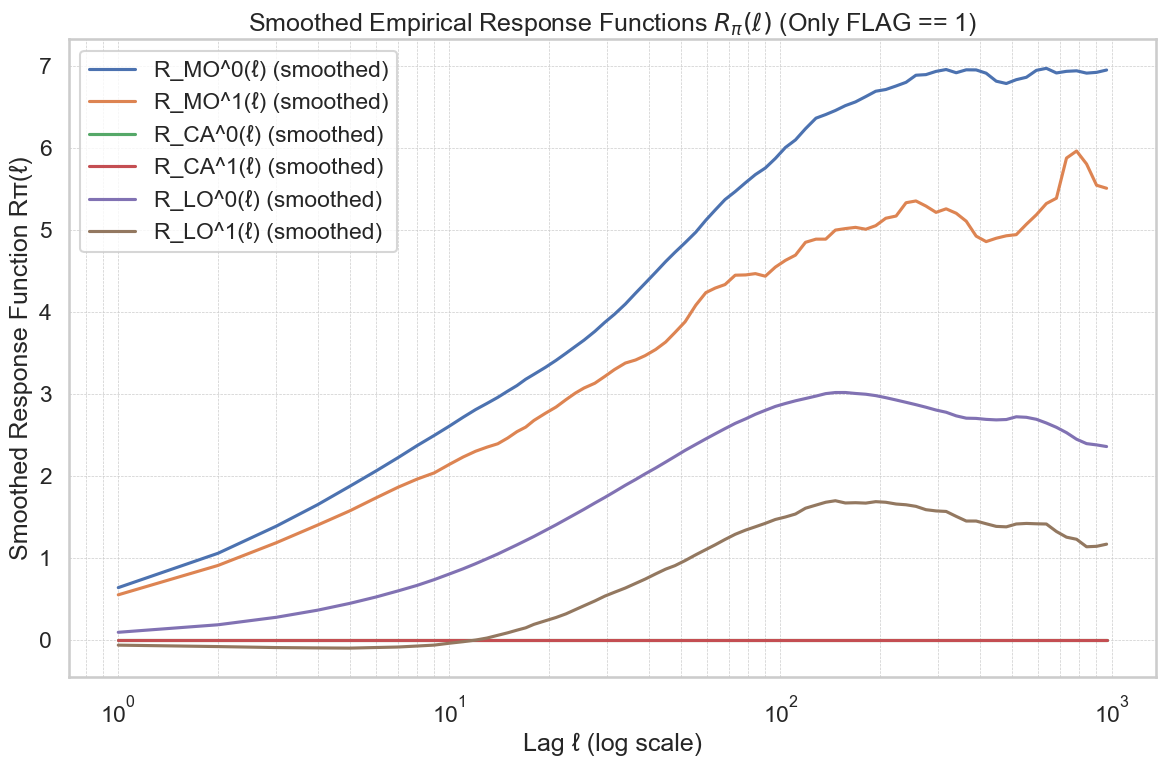

In [20]:
plt.figure(figsize=(12, 8))
for et in event_types:
    if et in response_functions_smoothed:
        x, y = response_functions_smoothed[et]
        plt.plot(x, y, label=f'R_{et}(ℓ) (smoothed)')
plt.xscale("log")
plt.xlabel('Lag ℓ (log scale)')
plt.ylabel('Smoothed Response Function Rπ(ℓ)')
plt.title('Smoothed Empirical Response Functions $R_\\pi(\\ell)$ (Only FLAG == 1)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### 3. **Signed Event-Event Correlations**  
   Compute the signed event-event correlations  
   $$
   C_{\pi_1, \pi_2}(\ell).
   $$  
   (Here, you will need these functions of all $\ell = 1, \ldots, \bar{\ell}$).


$$
C_{\pi_1, \pi_2}(\ell) = \frac{
\left\langle \mathbf{1}_{\pi_t = \pi_1} \, \epsilon_t \cdot \mathbf{1}_{\pi_{t+\ell} = \pi_2} \, \epsilon_{t+\ell} \right\rangle
}{
\mathbb{P}(\pi_1) \cdot \mathbb{P}(\pi_2)
}
$$

This captures the correlation between the signs of events of type $ \pi_1 $ at time $ t $ and events of type $ \pi_2 $ at time $ t + \ell $, normalized by the probabilities of observing each event type.

In [ ]:
def compute_event_event_correlations(df, event_types, max_lag=1000):
    """
    Compute C_{π1, π2}(ℓ) for each ℓ=1..max_lag, and each pair (π1, π2).
    df must have 'event_type' ∈ event_types, and 'trade_sign' ∈ {±1,0}.
    """
    # Filter to only the columns we need, drop rows that have event_type = None
    df = df[df['event_type'].isin(event_types)][['event_type', 'trade_sign']].copy()
    df.reset_index(drop=True, inplace=True)

    cat_array = df['event_type'].values
    sign_array = df['trade_sign'].values
    N = len(df)

    # Probability of each event type
    p = {}
    for et in event_types:
        p[et] = np.mean(cat_array == et)

    correlations = {
        pi1: {pi2: np.full(max_lag, np.nan) for pi2 in event_types}
        for pi1 in event_types
    }

    # For each lag:
    for lag in tqdm(range(1, max_lag+1), desc="Computing C_{π1, π2}(ℓ)"):
        if lag >= N:
            break

        cat_t     = cat_array[:-lag]
        cat_tlag  = cat_array[ lag:]
        sign_t    = sign_array[:-lag]
        sign_tlag = sign_array[ lag:]

        for pi1 in event_types:
            mask_t = (cat_t == pi1)
            for pi2 in event_types:
                mask_tlag = (cat_tlag == pi2)
                combined_mask = mask_t & mask_tlag

                if not np.any(combined_mask):
                    numerator = 0.0
                else:
                    numerator = np.mean(sign_t[combined_mask] * sign_tlag[combined_mask])

                denom = p[pi1] * p[pi2]
                if denom == 0:
                    C_val = np.nan
                else:
                    C_val = numerator / denom

                correlations[pi1][pi2][lag - 1] = C_val

    return correlations

max_lag_corr = 1000  
correlations_sg = compute_event_event_correlations(df_sgg, event_types, max_lag=max_lag_corr)

lags_plot = np.arange(1, max_lag_corr+1)
pi1 = 'MO^0'



Computing C_{π1, π2}(ℓ): 100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


4. **Plot Mixed Correlation Function**  
   Plot the function  
   $$
   C_{MO', \pi_2}(\ell).
   $$  
   Note that a signed log-scale similar to the one presented in [6] can be obtained in matplotlib with:
   ```python
   ax.set_yscale('symlog')

/Users/hugo/anaconda3/envs/envFreq/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


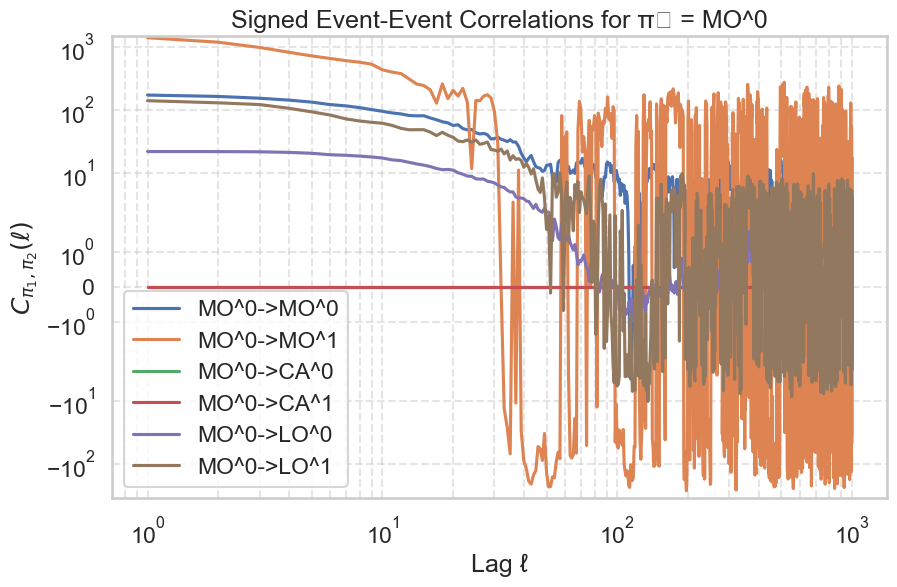

<Figure size 640x480 with 0 Axes>

In [22]:
plt.figure(figsize=(10,6))
for pi2 in event_types:
    corr_vals = correlations_sg[pi1][pi2]
    plt.plot(lags_plot, corr_vals, label=f"{pi1}->{pi2}")
plt.xlabel("Lag ℓ")
plt.ylabel(r"$C_{\pi_1,\pi_2}(\ell)$")
plt.title(f"Signed Event-Event Correlations for π₁ = {pi1}")
plt.xscale('log')       # optional: log scale on x
plt.yscale('symlog')    # optional: signed log scale on y
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [23]:
def moving_average(data, window_size=10):
    """
    Return a simple moving average of 'data' over a given 'window_size'.
    Edges are truncated (same mode) for simplicity.
    """
    if window_size < 2:
        return data  # no smoothing if window_size=1
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='same')


/var/folders/nd/lbp9nypd0l328jm0b27jr8c00000gn/T/ipykernel_20907/538606396.py:25: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()


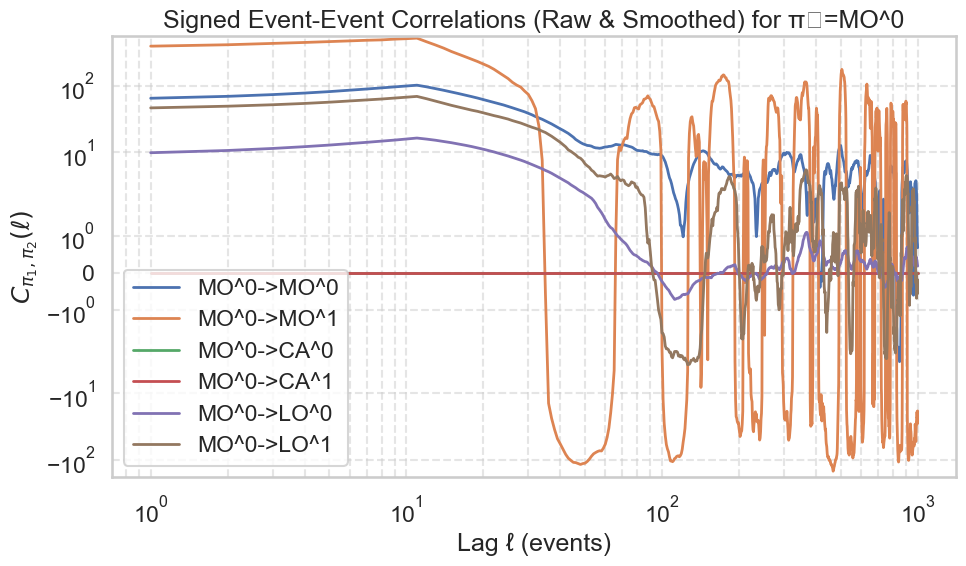

In [26]:
window_size = 20  # set your preferred smoothing window
lags_plot = np.arange(1, max_lag_corr + 1)

pi1 = 'MO^0'
plt.figure(figsize=(10, 6))

for pi2 in event_types:
    corr_vals = correlations_sg[pi1][pi2]

    corr_smooth = moving_average(corr_vals, window_size=window_size)

    # Plot raw correlation (fainter)
    #plt.plot(lags_plot, corr_vals, alpha=0.3, label=f"{pi1}->{pi2}")

    # Plot smoothed correlation (bolder)
    plt.plot(lags_plot, corr_smooth, linewidth=2, label=f"{pi1}->{pi2}")

plt.xlabel("Lag ℓ (events)")
plt.ylabel(r"$C_{\pi_1,\pi_2}(\ell)$")
plt.title(f"Signed Event-Event Correlations (Raw & Smoothed) for π₁={pi1}")
plt.xscale('log')        # optional
plt.yscale('symlog')     # optional
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


5. Compute the theoretical responses in the constant impact model, and compare them to
the empirical ones. Comment

In [ ]:
def compute_bare_impacts(df, event_types):

    dff = df[df["event_type"].isin(event_types)].copy()
    dff.reset_index(drop=True, inplace=True)

    dff["mid_next"] = dff["mid"].shift(-1)  # next event's mid
    dff["price_diff_sign"] = (dff["mid_next"] - dff["mid"]) * dff["trade_sign"]

    bare_impacts = {}
    for pi in event_types:
        mask = (dff["event_type"] == pi)
        vals = dff.loc[mask, "price_diff_sign"].dropna()  # drop last row if no next
        if len(vals) == 0:
            bare_impacts[pi] = 0.0
        else:
            bare_impacts[pi] = vals.mean()
    return bare_impacts


In [ ]:
def compute_theoretical_responses(event_types, correlations, bare_impacts, probabilities, max_lag):

    theoretical_resps = {pi: np.zeros(max_lag) for pi in event_types}

    partial_corr_sums = {}
    for pi in event_types:
        partial_corr_sums[pi] = {}
        for pi2 in event_types:
            cvals = correlations[pi][pi2]  
            cumu = np.nancumsum(cvals)
            partial_corr_sums[pi][pi2] = cumu

    for pi in event_types:
        for l in range(1, max_lag+1):
            val = 0.0
            for pi2 in event_types:
                c_sum = partial_corr_sums[pi][pi2][l-1]
                val += bare_impacts[pi2] * probabilities[pi2] * c_sum
            theoretical_resps[pi][l-1] = val

    return theoretical_resps


In [ ]:
P = {}
for pi in event_types:
    P[pi] = np.mean(df_sgg["event_type"] == pi)

In [ ]:

bare_impacts = compute_bare_impacts(df_sgg, event_types)

probabilities = {}
for pi in event_types:
    probabilities[pi] = np.mean(df_sgg["event_type"] == pi)


theoretical_responses = compute_theoretical_responses(
    event_types=event_types,
    correlations=correlations_sg,  
    bare_impacts=bare_impacts,
    probabilities=probabilities,
    max_lag=max_lag_corr
)




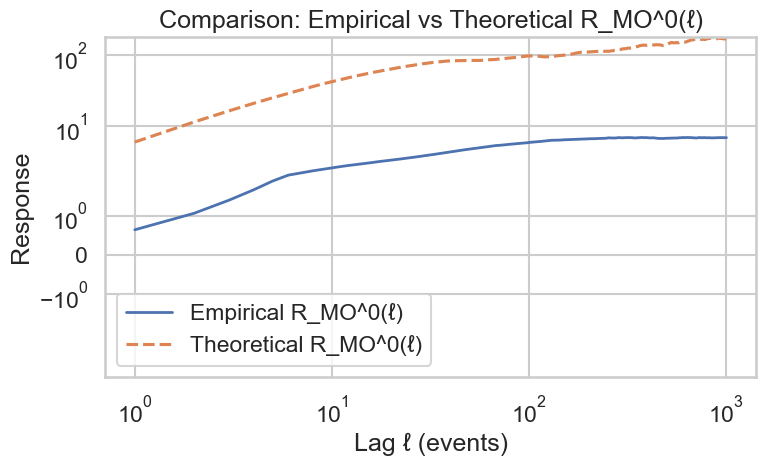

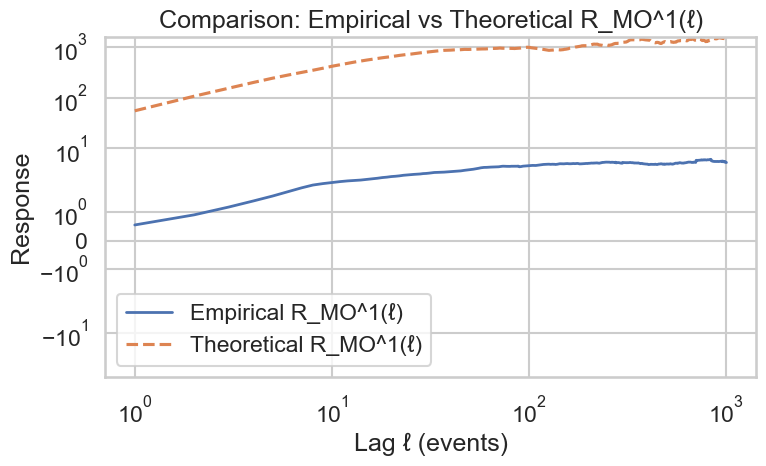

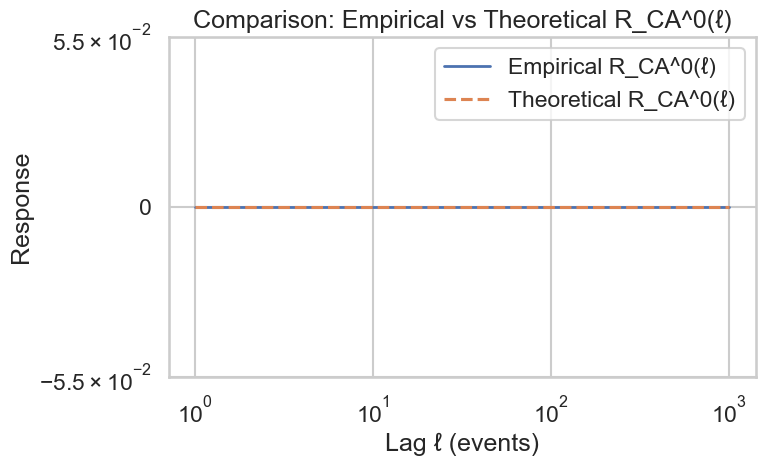

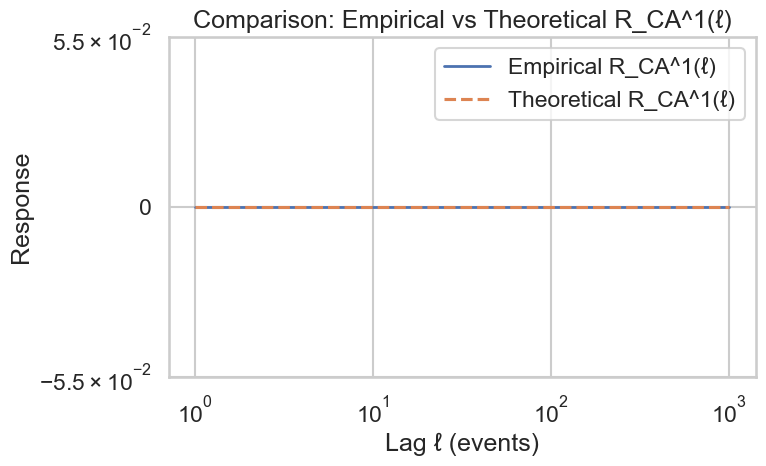

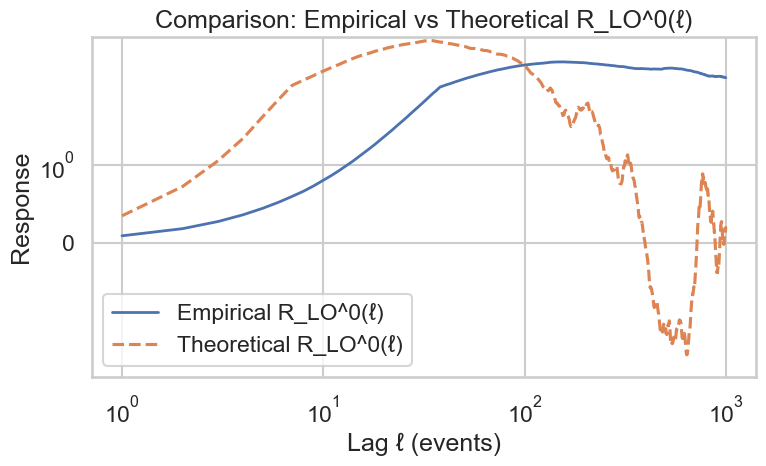

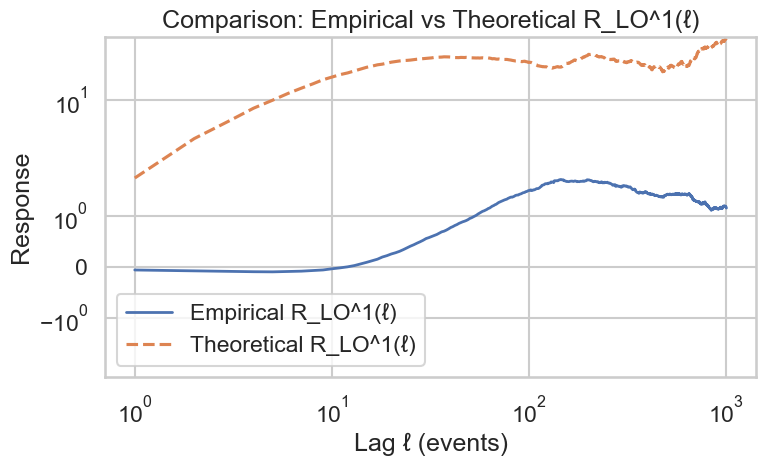

In [ ]:
lags_arr = np.arange(1, max_lag_corr+1)

for pi in event_types:
    plt.figure(figsize=(8,5))

    R_emp = np.array(response_functions[pi][:max_lag_corr])  

    R_theo = theoretical_responses[pi]

    plt.plot(lags_arr, R_emp, label=f"Empirical R_{pi}(ℓ)", linewidth=2)
    plt.plot(lags_arr, R_theo, label=f"Theoretical R_{pi}(ℓ)", linestyle='--')

    plt.xscale('log')  
    plt.yscale('symlog') 
    plt.grid(True)
    plt.xlabel("Lag ℓ (events)")
    plt.ylabel("Response")
    plt.title(f"Comparison: Empirical vs Theoretical R_{pi}(ℓ)")
    plt.legend()
    plt.tight_layout()
    plt.show()